In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, rectMask, mergeMasks, circularMask
from pepe.simulate import genSyntheticResponse
from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import g2HoughCircle

import numpy as np

import cv2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

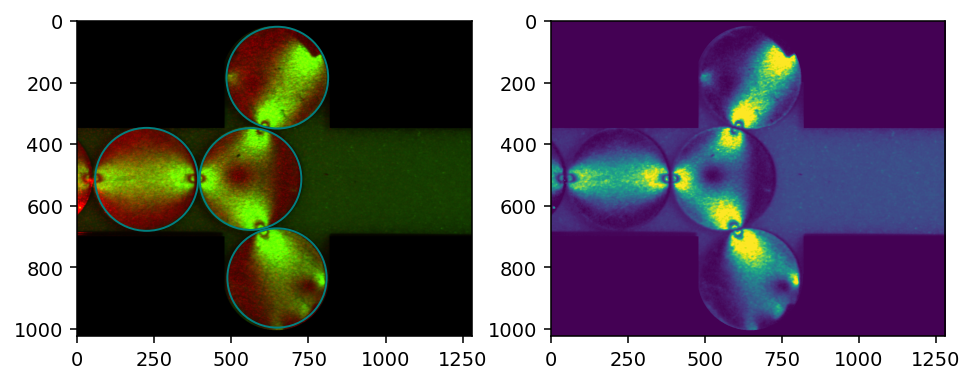

In [42]:
# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

image = checkImageType('test_data/Test_2022-01-28.bmp')
#photoelasticChannel = cv2.blur(image[:,:,1], (30,30))
# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = g2HoughCircle(image[:,:,0], [160, 180], accumulatorThreshold=20, cannyEdgeThreshold=80)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

# A particle is about 1cm across
pxPerMeter = 2*np.mean(radii) / .01
# No idea what the actual value for this is
fSigma = 100

# Create a cross-shaped channel, with some parts on the ends
maskArr = crossMask(image.shape, xlim=np.array([478, 818]), ylim=np.array([350, 700]))

semiCircleMask = mergeMasks(np.array([rectMask(image.shape, corner=np.array([0,400]), dimensions=np.array([200, 500])),
                             circularMask(image.shape, np.array([190, 640]), np.mean(radii)+7)]),
                           signs=np.array([1,-1], dtype=np.int16)) 

semiCircleMask2 = mergeMasks(np.array([rectMask(image.shape, corner=np.array([0,400]), dimensions=np.array([200, 500])),
                             circularMask(image.shape, np.array([190, 645]), np.mean(radii)+7)]),
                           signs=np.array([1,-1], dtype=np.int16)) 

listOfMasks = np.array([maskArr,
                       semiCircleMask,
                       semiCircleMask2[::-1]])

maskArr = mergeMasks(listOfMasks, signs=np.array([1,-1,-1], dtype=np.int16))


ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

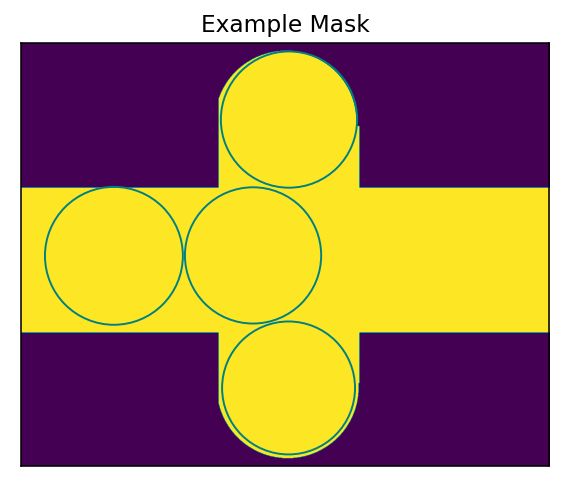

In [43]:
fig, ax = plt.subplots()

ax.imshow(maskArr[:,:,0])
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax.add_artist(c)


ax.set_title('Example Mask')
#ax.colorbar()
#plt.savefig('../images/example_uses/example_mask.png')
plt.show()

## Find initial guess

In [44]:
# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 3
contactMaskRadius = 30
#pxPerMeter = 10000
brightfield = False

forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(photoelasticChannel,
                                                centers, radii, fSigma, pxPerMeter,
                                                contactPadding, g2MaskPadding,
                                                contactMaskRadius=contactMaskRadius,
                                                boundaryMask=maskArr, ignoreBoundary=False)

#forceGuessArr /= np.max([np.max(f) for f in forceGuessArr])

## Show initial guess

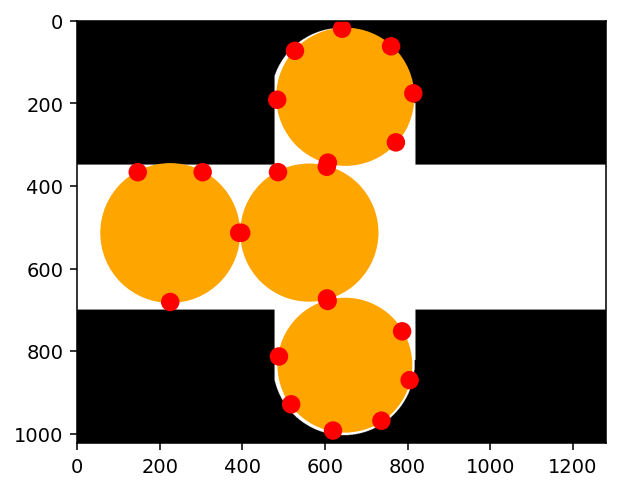

In [45]:
# Draw on all of the found contacts
fig, ax = plt.subplots()

ax.imshow(maskArr*255)

for i in range(len(centers)):
    # particle itself
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particle', color='orange')
    ax.add_artist(c)
    
    # Now add contacts
    for j in range(len(betaGuessArr[i])):
        contactPoint = centers[i] + radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])
        #linePoints = np.array([centers[i], radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])])
        #plt.plot(linePoints[0], linePoints[1], color='blue')
        cc = plt.Circle(contactPoint[::-1], 20, color='red')
        ax.add_artist(cc)
        
plt.show()

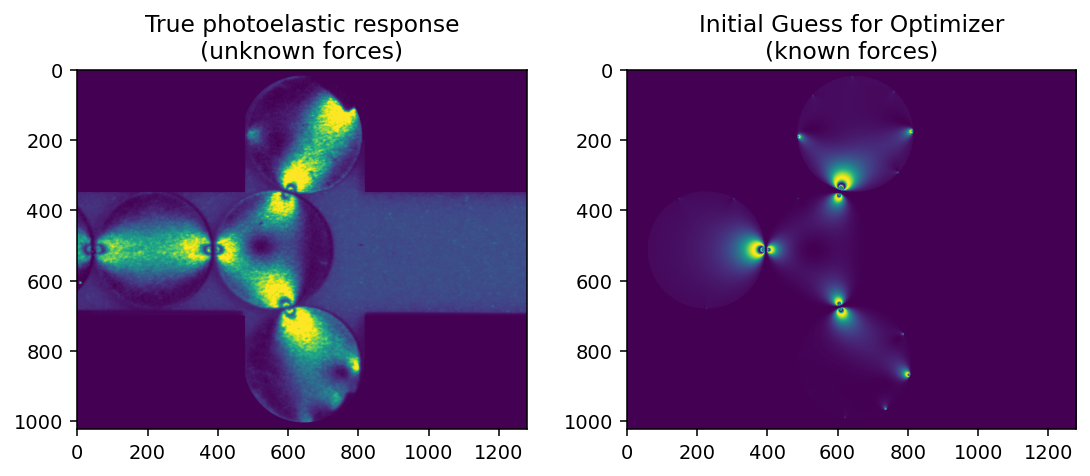

Absolute error (entire system): -161191.7971153943


In [46]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel * maskArr[:,:,0])
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros_like(photoelasticChannel, dtype=np.float64)

for i in range(len(centers)):
    estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[i]),
                                                         np.array(alphaGuessArr[i]),
                                                         np.array(betaGuessArr[i]),
                                                         fSigma, radii[i],
                                                         pxPerMeter, brightfield, imageSize=photoelasticChannel.shape,
                                                         center=centers[i])


ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Initial Guess for Optimizer\n(known forces)')

fig.tight_layout()
plt.show()

print(f'Absolute error (entire system): {np.sum(estimatedPhotoelasticChannel - photoelasticChannel)}')

## Optimize forces

In [47]:
# Now optimize each particle's forces
optimizedForceArr = []
optimizedBetaArr = []
optimizedAlphaArr = []

for i in range(len(centers)):
    optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(forceGuessArr[i], betaGuessArr[i], alphaGuessArr[i], radii[i], centers[i], photoelasticChannel,
                                                              fSigma, pxPerMeter, brightfield, maxEvals=[300, 200], method='nelder',
                                                              parametersToFit=[['f', 'b'], ['f', 'a']], betaTol=.4)
    optimizedForceArr.append(optForceArr)
    optimizedBetaArr.append(optBetaArr)
    optimizedAlphaArr.append(optAlphaArr)

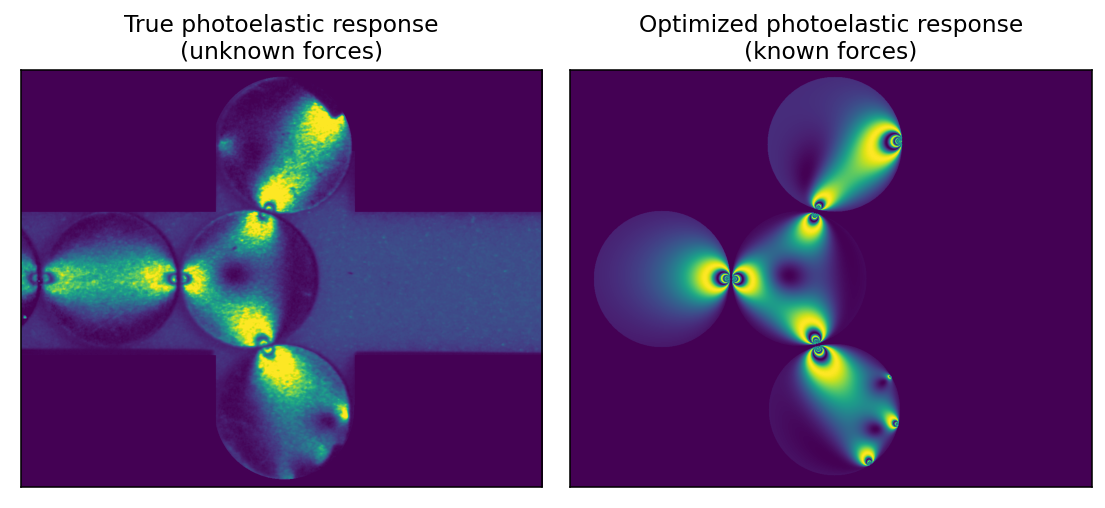

Absolute error (entire system): -87035.9015585734


In [48]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel * maskArr[:,:,0])
ax[0].set_title('True photoelastic response\n(unknown forces)')
ax[0].set_xticks([])
ax[0].set_yticks([])

optimizedPhotoelasticChannel = np.zeros(photoelasticChannel.shape)

for i in range(len(centers)):
    optimizedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[i]),
                                                         np.array(optimizedAlphaArr[i]),
                                                         np.array(optimizedBetaArr[i]),
                                                         fSigma, radii[i], pxPerMeter, brightfield,
                                                         imageSize=photoelasticChannel.shape, center=centers[i])


ax[1].imshow(optimizedPhotoelasticChannel)
ax[1].set_title('Optimized photoelastic response\n(known forces)')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
plt.savefig('../images/example_uses/space_jam_test.png')
plt.show()

print(f'Absolute error (entire system): {np.sum(optimizedPhotoelasticChannel - photoelasticChannel)}')

In [16]:
optimizedForceArr

[array([0.14489717]),
 array([0.1240253 , 0.09132256, 0.12397449]),
 array([0.11369005, 0.11547726, 0.05191486]),
 array([0.14555599, 0.02310561, 0.09234012, 0.07056692])]

In [15]:
optimizedAlphaArr

[array([0.1]),
 array([9.85828127e-02, 9.99098450e-02, 9.80750615e-08]),
 array([0.03014407, 0.00349687, 0.08064952]),
 array([0.00011762, 0.09193884, 0.09952264, 0.09298437])]